# Data Mining Cup Task - 2019
For Predictive Analytics, all homework assignments are building on constructing a solution for the 2019 Data Mining Cup task. This folder is for combining all homework code and producing a final solution of test set predicted likelihoods and the associated cut-off value.

In [1]:
## Importing all necessary libraries:

import boto3
import pandas as pd
import numpy as np
import seaborn as sns
import dmc_cost_function as dmc
import precision_recall_cutoff as prc
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, make_scorer
pd.set_option('display.max_columns', 50)

In [2]:
## Reading in the data sets

## Defining the bucket
s3 = boto3.resource('s3')
bucket_name = 'data-448-bucket-callaghan'
bucket = s3.Bucket(bucket_name)

file_key = 'train.csv'
file_key2 = 'test.csv'

bucket_object = bucket.Object(file_key)
bucket_object2 = bucket.Object(file_key2)

file_object = bucket_object.get()
file_object2 = bucket_object2.get()

file_content_stream = file_object.get('Body')
file_content_stream2 = file_object2.get('Body')

train = pd.read_csv(file_content_stream, sep = '|')
test = pd.read_csv(file_content_stream2, sep = '|')

train.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0


## Initial Exploration

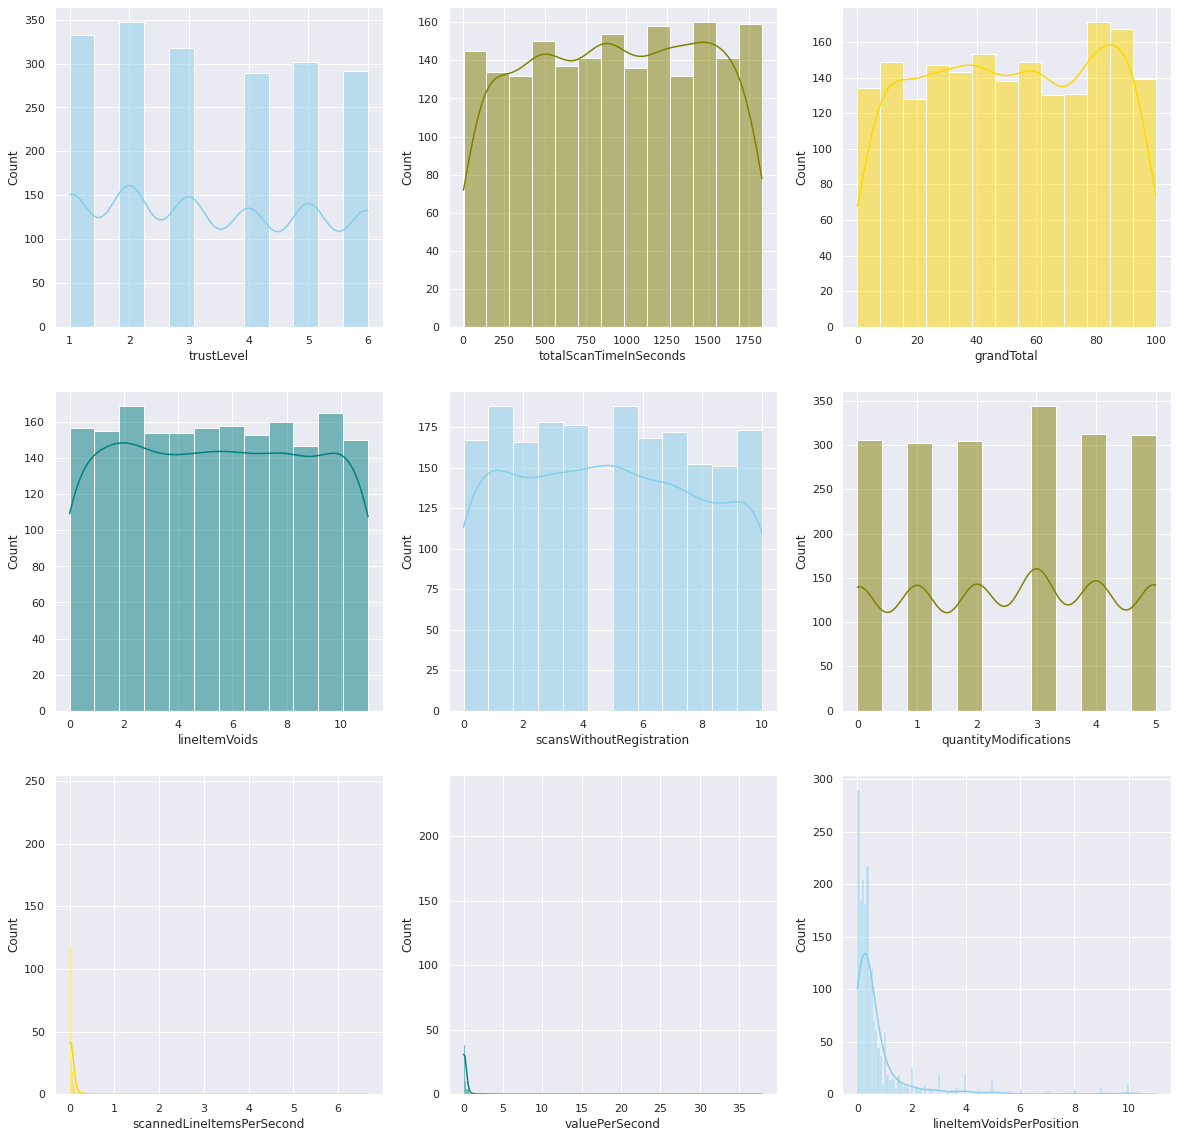

In [3]:
sns.set(style="darkgrid")

fig, axs = plt.subplots(3, 3, figsize=(20, 20))

sns.histplot(data=train, x="trustLevel", kde=True, color="skyblue", ax=axs[0, 0])
sns.histplot(data=train, x="totalScanTimeInSeconds", kde=True, color="olive", ax=axs[0, 1])
sns.histplot(data=train, x="grandTotal", kde=True, color="gold", ax=axs[0, 2])
sns.histplot(data=train, x="lineItemVoids", kde=True, color="teal", ax=axs[1, 0])
sns.histplot(data=train, x="scansWithoutRegistration", kde=True, color="skyblue", ax=axs[1, 1])
sns.histplot(data=train, x="quantityModifications", kde=True, color="olive", ax=axs[1, 2])
sns.histplot(data=train, x="scannedLineItemsPerSecond", kde=True, color="gold", ax=axs[2, 0])
sns.histplot(data=train, x="valuePerSecond", kde=True, color="teal", ax=axs[2, 1])
sns.histplot(data=train, x="lineItemVoidsPerPosition", kde=True, color="skyblue", ax=axs[2, 2])

plt.show()

## Data Cleaning

In [3]:
## Performing cube root transformation on: scannedLineItemsPerSecond, valuePerSecond, and lineItemVoidsPerPosition

train['scannedLineItemsPerSecond'] = np.cbrt(train['scannedLineItemsPerSecond'])
test['scannedLineItemsPerSecond'] = np.cbrt(test['scannedLineItemsPerSecond'])

train['valuePerSecond'] = np.cbrt(train['valuePerSecond'])
test['valuePerSecond'] = np.cbrt(test['valuePerSecond'])

train['lineItemVoidsPerPosition'] = np.cbrt(train['lineItemVoidsPerPosition'])
test['lineItemVoidsPerPosition'] = np.cbrt(test['lineItemVoidsPerPosition'])

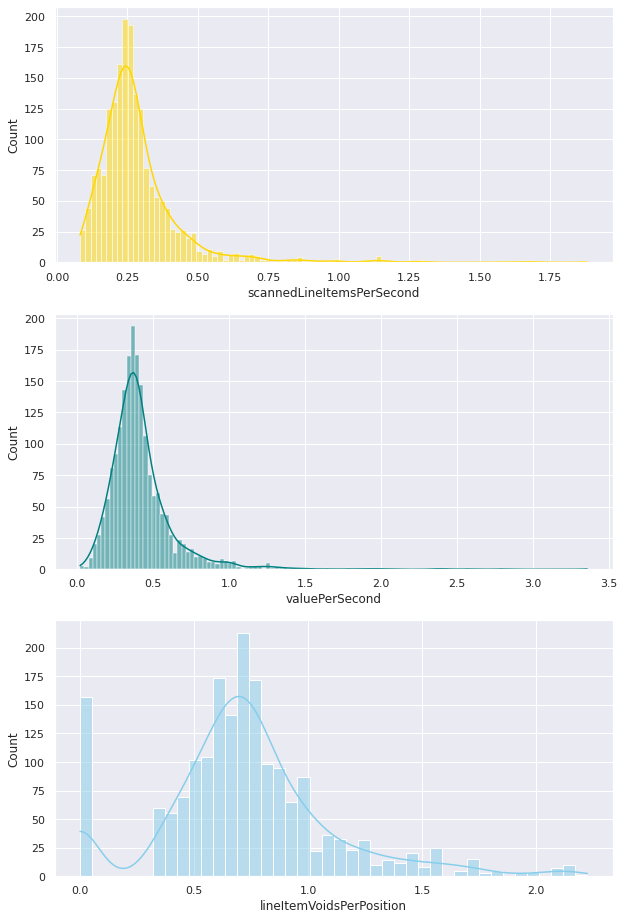

In [4]:
sns.set(style="darkgrid")

fig, axs = plt.subplots(3, 1, figsize=(10, 16))

sns.histplot(data=train, x="scannedLineItemsPerSecond", kde=True, color="gold", ax=axs[0])
sns.histplot(data=train, x="valuePerSecond", kde=True, color="teal", ax=axs[1])
sns.histplot(data=train, x="lineItemVoidsPerPosition", kde=True, color="skyblue", ax=axs[2])

plt.show()

## Variable Engineering

In [6]:
## Engineering features by using the strong heredity principle. That is, identifying the top features and 
## engineering the interaction between them.

## Defining the input and target variables
X = train.drop(columns = ['fraud'])
Y = train['fraud']

## Defining a list to store results
results = []

## Repeating process 100 times
for i in range(0, 100):
    
    ## Splitting the data
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)
    
    ## Building the model
    rf_md = RandomForestClassifier(max_depth = 3, n_estimators = 500).fit(X_train, Y_train)
    
    ## Extracting feature importance scores
    results.append(rf_md.feature_importances_)
    
## Changing results list to a dataframe
results = pd.DataFrame(results, columns = X.columns)

## Computing averages and sorting variables by importance
results = pd.DataFrame(results.apply(np.mean, axis = 0))
results = pd.DataFrame({'Feature': results.index, 'Importance': results[0].values}).sort_values(by = 'Importance', ascending = False)

results

,Feature,Importance
0,trustLevel,0.447798
6,scannedLineItemsPerSecond,0.152489
1,totalScanTimeInSeconds,0.112829
8,lineItemVoidsPerPosition,0.108151
7,valuePerSecond,0.061883
2,grandTotal,0.042920
3,lineItemVoids,0.042088
4,scansWithoutRegistration,0.028949
5,quantityModifications,0.002893


[Text(643.8461538461538, 761.04, 'trustLevel <= 1.5\ngini = 0.104\nsamples = 1503\nvalue = [1420, 83]'),
 Text(343.38461538461536, 543.6, 'lineItemVoidsPerPosition <= 0.774\ngini = 0.405\nsamples = 252\nvalue = [181, 71]'),
 Text(171.69230769230768, 326.15999999999997, 'totalScanTimeInSeconds <= 873.0\ngini = 0.49\nsamples = 161\nvalue = [92, 69]'),
 Text(85.84615384615384, 108.72000000000003, 'gini = 0.372\nsamples = 81\nvalue = [61, 20]'),
 Text(257.53846153846155, 108.72000000000003, 'gini = 0.475\nsamples = 80\nvalue = [31, 49]'),
 Text(515.0769230769231, 326.15999999999997, 'valuePerSecond <= 0.142\ngini = 0.043\nsamples = 91\nvalue = [89, 2]'),
 Text(429.23076923076917, 108.72000000000003, 'gini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(600.9230769230769, 108.72000000000003, 'gini = 0.022\nsamples = 89\nvalue = [88, 1]'),
 Text(944.3076923076923, 543.6, 'trustLevel <= 2.5\ngini = 0.019\nsamples = 1251\nvalue = [1239, 12]'),
 Text(858.4615384615383, 326.15999999999997, 'totalSca

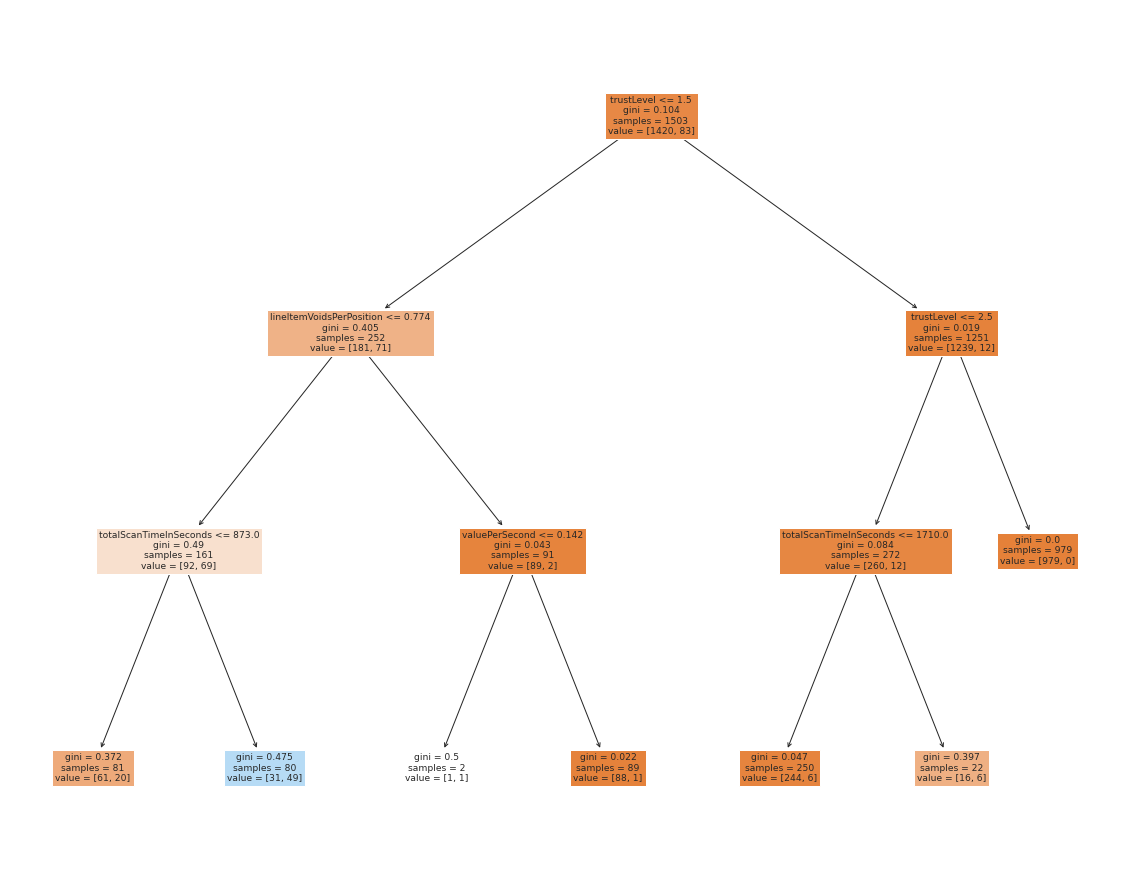

In [9]:
## Creating decision tree to find new feature relationships

## Defining the input and target variables
X = train.drop(columns = ['fraud'])
Y = train['fraud']

## Splitting the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)

## Building a decision tree model with max depth = 3 on the train data-frame
tree_md = DecisionTreeClassifier(max_depth = 3).fit(X_train, Y_train)

## Visualizing the decision tree model and identify any interesting interactions/features
fig = plt.figure(figsize = (20, 16))
plot_tree(tree_md, feature_names = X.columns, filled = True)

In [5]:
## From DecisionTree

train['Tree_1'] = np.where((train['trustLevel'] <= 1.5) & (train['lineItemVoidsPerPosition'] <= 0.774) & 
                                  (train['totalScanTimeInSeconds'] <= 873.0), 1, 0)
test['Tree_1'] = np.where((test['trustLevel'] <= 1.5) & (test['lineItemVoidsPerPosition'] <= 0.774) & 
                                  (test['totalScanTimeInSeconds'] <= 873.0), 1, 0)

train['Tree_2'] = np.where((train['trustLevel'] <= 1.5) & (train['lineItemVoidsPerPosition'] <= 0.774) & 
                                  (train['totalScanTimeInSeconds'] > 873.0), 1, 0)
test['Tree_2'] = np.where((test['trustLevel'] <= 1.5) & (test['lineItemVoidsPerPosition'] <= 0.774) & 
                                  (test['totalScanTimeInSeconds'] > 873.0), 1, 0)


train['Tree_3'] = np.where((train['trustLevel'] <= 1.5) & (train['lineItemVoidsPerPosition'] > 0.774) & 
                                  (train['valuePerSecond'] <= 0.142), 1, 0)
test['Tree_3'] = np.where((test['trustLevel'] <= 1.5) & (test['lineItemVoidsPerPosition'] > 0.774) & 
                                  (test['valuePerSecond'] <= 0.142), 1, 0)

train['Tree_4'] = np.where((train['trustLevel'] <= 1.5) & (train['lineItemVoidsPerPosition'] > 0.774) & 
                                  (train['valuePerSecond'] > 0.142), 1, 0)
test['Tree_4'] = np.where((test['trustLevel'] <= 1.5) & (test['lineItemVoidsPerPosition'] > 0.774) & 
                                  (test['valuePerSecond'] > 0.142), 1, 0)


train['Tree_5'] = np.where((train['trustLevel'] > 1.5) & (train['trustLevel'] <= 2.5) & 
                                  (train['totalScanTimeInSeconds'] <= 1710.0), 1, 0)
test['Tree_5'] = np.where((test['trustLevel'] > 1.5) & (test['trustLevel'] <= 2.5) & 
                                  (test['totalScanTimeInSeconds'] <= 1710.0), 1, 0)

train['Tree_6'] = np.where((train['trustLevel'] > 1.5) & (train['trustLevel'] <= 2.5) & 
                                  (train['totalScanTimeInSeconds'] > 1710.0), 1, 0)
test['Tree_6'] = np.where((test['trustLevel'] > 1.5) & (test['trustLevel'] <= 2.5) & 
                                  (test['totalScanTimeInSeconds'] > 1710.0), 1, 0)


train['Tree_7'] = np.where((train['trustLevel'] > 1.5) & (train['trustLevel'] > 2.5), 1, 0)
test['Tree_7'] = np.where((test['trustLevel'] > 1.5) & (test['trustLevel'] > 2.5), 1, 0)

In [6]:
## From variable importance scores

train['Interaction_1'] = train['trustLevel'] * train['scannedLineItemsPerSecond']
test['Interaction_1'] = test['trustLevel'] * test['scannedLineItemsPerSecond']

train['Interaction_2'] = train['trustLevel'] * train['totalScanTimeInSeconds']
test['Interaction_2'] = test['trustLevel'] * test['totalScanTimeInSeconds']

train['Interaction_3'] = train['trustLevel'] * train['lineItemVoidsPerPosition']
test['Interaction_3'] = test['trustLevel'] * test['lineItemVoidsPerPosition']

train['Interaction_4'] = train['scannedLineItemsPerSecond'] * train['totalScanTimeInSeconds']
test['Interaction_4'] = test['scannedLineItemsPerSecond'] * test['totalScanTimeInSeconds']

train['Interaction_5'] = train['scannedLineItemsPerSecond'] * train['lineItemVoidsPerPosition']
test['Interaction_5'] = test['scannedLineItemsPerSecond'] * test['lineItemVoidsPerPosition']

train['Interaction_6'] = train['totalScanTimeInSeconds'] * train['lineItemVoidsPerPosition']
test['Interaction_6'] = test['totalScanTimeInSeconds'] * test['lineItemVoidsPerPosition']

In [7]:
## From observations of the data

train['madeModification'] = np.where(train['quantityModifications'] > 0, 1, 0)
test['madeModification'] = np.where(test['quantityModifications'] > 0, 1, 0)

train['madeScansWithoutRegistration'] = np.where(train['scansWithoutRegistration'] > 0, 1, 0)
test['madeScansWithoutRegistration'] = np.where(test['scansWithoutRegistration'] > 0, 1, 0)

train['lowTotalScanTime'] = np.where(train['totalScanTimeInSeconds'] < 1000, 1, 0)
test['lowTotalScanTime'] = np.where(test['totalScanTimeInSeconds'] < 1000, 1, 0)

In [8]:
## Creating a dummy variable with trustLevel

train = pd.concat([train.drop(columns = ['trustLevel']), pd.get_dummies(train['trustLevel'])], axis = 1)
test = pd.concat([test.drop(columns = ['trustLevel']), pd.get_dummies(test['trustLevel'])], axis = 1)

train = train.rename(columns = { 1: 'trustLevel_1', 2: 'trustLevel_2', 3: 'trustLevel_3', 
                                4: 'trustLevel_4', 5: 'trustLevel_5', 6: 'trustLevel_6'})
test = test.rename(columns = { 1: 'trustLevel_1', 2: 'trustLevel_2', 3: 'trustLevel_3', 
                                4: 'trustLevel_4', 5: 'trustLevel_5', 6: 'trustLevel_6'})

In [9]:
train.shape

(1879, 31)

In [10]:
train.head()

,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud,Tree_1,Tree_2,Tree_3,Tree_4,Tree_5,Tree_6,Tree_7,Interaction_1,Interaction_2,Interaction_3,Interaction_4,Interaction_5,Interaction_6,madeModification,madeScansWithoutRegistration,lowTotalScanTime,trustLevel_1,trustLevel_2,trustLevel_3,trustLevel_4,trustLevel_5,trustLevel_6
0,1054,54.70,7,0,3,0.301893,0.373006,0.622635,0,0,0,0,0,0,0,1,1.509463,5270,3.113174,318.194796,0.187969,656.257014,1,0,0,0,0,0,0,1,0
1,108,27.36,5,2,4,0.506098,0.632748,0.709492,0,0,0,0,0,0,0,1,1.518294,324,2.128475,54.658601,0.359072,76.625104,1,1,1,0,0,1,0,0,0
2,1516,62.16,3,10,5,0.204683,0.344829,0.613375,0,0,0,0,0,0,0,1,0.614048,4548,1.840125,310.299149,0.125547,929.876278,1,1,0,0,0,1,0,0,0
3,1791,92.31,8,4,4,0.252989,0.372150,0.650975,0,0,0,0,0,0,0,1,1.517931,10746,3.905847,453.102428,0.164689,1165.895382,1,1,0,0,0,0,0,0,1
4,430,81.53,3,7,2,0.397465,0.574491,0.480750,0,0,0,0,0,0,0,1,1.987323,2150,2.403749,170.909771,0.191081,206.722438,1,1,1,0,0,0,0,1,0


## Modeling + Feature Selection

In [11]:
## Defining the input and target variables
X = train.drop(columns = ['fraud'])
Y = train['fraud']

## Splitting the data into training, validation, and testing sets
X_training, X_, Y_training, Y_ = train_test_split(X, Y, test_size = 0.2, stratify = Y)

X_validation, X_testing, Y_validation, Y_testing = train_test_split(X_, Y_, test_size = 0.5, stratify = Y_)

In [16]:
## Creating a customized scoring function to evaluate performance

my_scorer = make_scorer(dmc.cost_function, greater_is_better = True, needs_proba = True)

In [15]:
## RFECV with DecisionTreeClassifier

## Defining an empty list to store results
rfecv_results = []

## Repeating the process 10 times
for i in range(0, 10):
    
    ## Building the RFECV model
    tree_rfecv = RFECV(estimator = DecisionTreeClassifier(), step = 1, min_features_to_select = 2, 
                       cv = 3, scoring = my_scorer).fit(X_training, Y_training)
    
    ## Appending results to list
    rfecv_results.append(tree_rfecv.support_)
    
## Returning results of RFECV
tree = pd.DataFrame(rfecv_results, columns = X_training.columns)
tree = 100 * tree.apply(np.sum, axis = 0) / tree.shape[0]
pd.DataFrame(tree).sort_values(0, ascending = False).T

,Tree_2,Interaction_4,Interaction_2,scannedLineItemsPerSecond,Tree_1,Interaction_5,Interaction_3,scansWithoutRegistration,Interaction_1,Tree_3,grandTotal,lineItemVoidsPerPosition,Interaction_6,valuePerSecond,quantityModifications,madeModification,lineItemVoids,madeScansWithoutRegistration,lowTotalScanTime,trustLevel_2,trustLevel_3,trustLevel_1,trustLevel_5,trustLevel_4,totalScanTimeInSeconds,Tree_7,Tree_6,Tree_5,Tree_4,trustLevel_6
0,100.0,100.0,90.0,90.0,80.0,80.0,80.0,80.0,70.0,50.0,50.0,30.0,30.0,20.0,20.0,20.0,20.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
## RFECV with LogisticRegression

## Defining an empty list to store results
rfecv_results = []

## Repeating the process 10 times
for i in range(0, 10):
    
    ## Building the RFECV model
    logit_rfecv = RFECV(estimator = LogisticRegression(max_iter = 10000), step = 1, min_features_to_select = 2, 
                        cv = 3, scoring = my_scorer).fit(X_training, Y_training)
    
    ## Appending results to list
    rfecv_results.append(logit_rfecv.support_)
    
## Returning results of RFECV
logit = pd.DataFrame(rfecv_results, columns = X_training.columns)
logit = 100 * logit.apply(np.sum, axis = 0) / logit.shape[0]
pd.DataFrame(logit).sort_values(0, ascending = False).T

,totalScanTimeInSeconds,Tree_6,trustLevel_3,trustLevel_2,trustLevel_1,lowTotalScanTime,madeScansWithoutRegistration,madeModification,Interaction_5,Interaction_4,Interaction_3,Interaction_2,Tree_7,trustLevel_6,Tree_5,Tree_4,Tree_3,Tree_2,Tree_1,lineItemVoidsPerPosition,valuePerSecond,scannedLineItemsPerSecond,quantityModifications,scansWithoutRegistration,lineItemVoids,grandTotal,Interaction_6,trustLevel_4,trustLevel_5,Interaction_1
0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,0.0,0.0,0.0,0.0,0.0


In [14]:
## Creating a customized scoring function
my_scorer = make_scorer(dmc.cost_function, greater_is_better = True, needs_proba = True)

## RFECV with LogisticRegression
tree_rfecv = RFECV(estimator = DecisionTreeClassifier(), step = 1, min_features_to_select = 2, 
                    cv = 3, scoring = my_scorer).fit(X_training, Y_training)

tree_rfecv.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [ ]:
## RFECV with DecisionTreeClassifier
tree_rfecv = RFECV(estimator = DecisionTreeClassifier(), step = 1, min_features_to_select = 2, 
                    cv = 3).fit(X_training, Y_training)

In [ ]:
## RFECV with GradientBoosting

In [ ]:
## RFECV with SupportVectorMachine (linear kernel)

In [ ]:
## RFECV with AdaBoost